In [1]:
import SimpleITK as sitk
import tensorflow.python
import numpy as np
import nibabel as nib
import scipy.misc
from tqdm import tqdm_notebook
import os
import cv2
from PIL import Image,ImageOps
import matplotlib.pyplot as plt # 描画用
import scipy.interpolate as interpolate

import SimpleITK as sitk
import tensorflow.python
import numpy as np
import nibabel as nib
import scipy.misc
from tqdm import tqdm_notebook
import os
import cv2
from PIL import Image,ImageOps
import matplotlib.pyplot as plt # 描画用
import scipy.interpolate as interpolate

In [83]:
os.path.join(path, f'case_00+*/{D_num}/*.mha')

'C:/Users/higuchi/Desktop/LAB/201906_/segmentation/data/label_sagittal\\case_00+*/1/*.mha'

In [92]:
import glob
D_num=1
path='C:/Users/higuchi/Desktop/LAB/201906_/segmentation/data/label_sagittal'
len(glob.glob(os.path.join(path, f'*/{D_num}/*.mha')))
     

3907

In [2]:
raw_seg = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"segmentation.nii.gz"))
raw_vol = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"imaging.nii.gz"))

In [130]:
import pandas as pd
df=pd.DataFrame(img0[:,:,img0.shape[2]//2])
df.mean().describe()

count     512.000000
mean     -215.743433
std       409.355529
min     -1005.315615
25%      -253.229651
50%       -74.736711
75%       112.794850
max       251.438538
dtype: float64

In [112]:
np.hstack((img0[:,:,img0.shape[2]//2].T,img0[:,:,260].T))

array([[ -981.,  -984., -1003., ..., -1012., -1009., -1011.],
       [ -980.,  -983.,  -996., ..., -1016., -1020., -1014.],
       [ -984.,  -991.,  -998., ..., -1013., -1020., -1015.],
       ...,
       [ -940.,  -944.,  -947., ...,  -916.,  -925.,  -933.],
       [ -939.,  -945.,  -948., ...,  -924.,  -931.,  -936.],
       [ -944.,  -947.,  -951., ...,  -950.,  -949.,  -939.]])

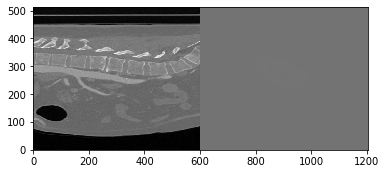

In [131]:
plt.imshow(img1[:,:,143].T,cmap='gray',origin='lower')
plt.imshow(np.hstack((img0[:,:,img0.shape[2]//2].T,img1[:,:,143].T)),cmap='gray',origin='lower')


(602, 512, 512)


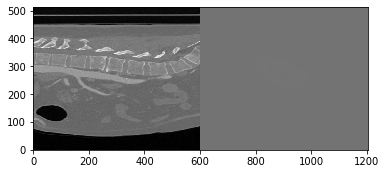

In [124]:
#             plt.imshow(clip_vol,cmap='gray',origin='lower')
#             plt.show()
nii1=raw_seg
img1=nii1.get_data()
#CT値のまま出力する方法
nii0=raw_vol
img0=nii0.get_data()
print(img0.shape) # 三次元配列の大きさ表示
#origin,軸をどこに取るか
plt.imshow(np.hstack((img0[:,:,img0.shape[2]//2].T,img1[:,:,143].T)),cmap='gray',origin='lower')
plt.savefig('.hoge.png')
# plt.show()

(602, 512, 512)


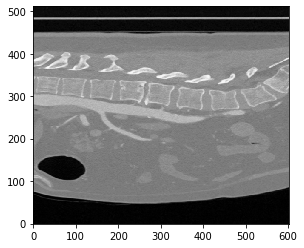

In [133]:
print(img0.shape) # 三次元配列の大きさ表示
plt.imshow(img0[:,:,img0.shape[2]//2].T,cmap='Greys_r',origin='lower')
plt.show()

In [ ]:
raw_seg = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"segmentation.nii.gz"))
raw_vol = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"imaging.nii.gz"))

In [5]:
%%time
#被験者00001を観察
#nib_ver
affine = raw_vol.affine
vol = raw_vol.get_data()
seg = raw_seg.get_data()

#{"case_id": "case_00001", "captured_pixel_width": 0.798828125, "captured_slice_thickness": 0.5}
print(seg[:,:,:].shape)
tmp_im=seg[:,:,150]
#slicerに合わせるように回転したのち反転してる
#0以外の部分はすべて255に変換している。
ret,thresh = cv2.threshold(tmp_im,0,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)

for i,contour in enumerate(contours):
    cnt = contour

    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
#     print ('重心:',M)
    print (f'{i}:面積:',area,'周囲長:',perimeter)


area=np.argmax(np.array([cv2.contourArea(cnt) for cnt in contours]))


(602, 512, 512)
0:面積: 6.0 周囲長: 9.656854152679443
1:面積: 108.0 周囲長: 51.455843567848206
2:面積: 723.0 周囲長: 200.99494767189026
3:面積: 23.0 周囲長: 20.485281229019165
4:面積: 42.5 周囲長: 26.727921843528748
5:面積: 8.5 周囲長: 13.071067571640015
6:面積: 4.0 周囲長: 7.656854152679443
7:面積: 11.5 周囲長: 13.899494767189026
8:面積: 10909.0 周囲長: 733.0681012868881
Wall time: 24.9 ms


### 作業手順
1. nibから読み込みnumpy_arrayにする
2. 枠線の中で最も大きいものを選択する。
3. 回転角を取っておく。rect,box,padding_boxを取得
4. seg,volどちらも回転させる。
5. 領域を獲得
6. ct値、画像ともに保存、逆行列が求まる状態の値を保存しておく。

たぶん、出力されたsegから元の画像が作成できればOK(CTの復元はいらない

In [ ]:
def rotate(image, angle, center):
    h, w = image.shape[:2]
    affine = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, affine, (w, h))


def load_data(cid, seg_path, vol_path):
    raw_seg = nib.load(seg_path)
    raw_vol = nib.load(vol_path)

    affine = raw_vol.affine
    raw_vol = raw_vol.get_data()
    raw_seg = raw_seg.get_data()
    return raw_vol, raw_seg


def get_slice_idx(raw_seg):
    rnumber = len(raw_seg[0, 0, :])
    imagefragarray = []
    sliceIndex = []

    # 高さ方向の腎臓、腎臓がんの範囲特定
    for x in range(rnumber):

        imagefragarray = raw_seg[:, :, x]

        if np.where(imagefragarray != 0, True, False).any():
            sliceIndex.append(x)

    return sliceIndex

def transform_img(slice_seg,slice_vol):
    contours, hierarchy = cv2.findContours(slice_seg, 1, 2)

    # 最大領域の取得
    max_id = np.argmax(np.array([cv2.contourArea(cnt) for cnt in contours]))
    max_countor = contours[max_id]
    rect = cv2.minAreaRect(max_countor)

    # 回転点,領域の大きさ,回転角
    center, size, degree = rect
    # 角度から4座標に変換
    box = cv2.boxPoints(rect)

    # 角度が0になった場合、関心領域はどこに写像されるか取得
    horizon_rect = (center, size, 0)
    horizon_box = cv2.boxPoints(horizon_rect)

    # (Left,Right,Top,Bottom:X,Y)
    LX = int(horizon_box[0, 0])
    RX = int(horizon_box[3, 0])
    TY = int(horizon_box[0, 1])
    UY = int(horizon_box[1, 1])

    if LX > RX:
        LX, RX = RX, LX

    if TY > UY:
        TY, UY = UY, TY

    # 画像全体を回転させる。
    rotate_vol_a = rotate(slice_vol, degree, center)
    rotate_seg_a = rotate(slice_seg, degree, center)

    clip_vol = rotate_vol_a[TY - PADDING_SIZE:UY + PADDING_SIZE, LX - PADDING_SIZE:RX + PADDING_SIZE]
    clip_seg = rotate_seg_a[TY - PADDING_SIZE:UY + PADDING_SIZE, LX - PADDING_SIZE:RX + PADDING_SIZE]
    box_shape = clip_seg.shape

    clip_vol = cv2.resize(
        clip_vol,
        dsize=(
            FIXED_SIZES[folder_num],
            FIXED_SIZES[folder_num]),
        interpolation=cv2.INTER_CUBIC)

    clip_seg = cv2.resize(
        clip_seg,
        dsize=(
            FIXED_SIZES[folder_num],
            FIXED_SIZES[folder_num]),
        interpolation=cv2.INTER_CUBIC)

    return clip_vol,clip_seg,degree,center

In [ ]:
# 周囲の余白の大きさ
PADDING_SIZE = 20
# 各スライスの学習データの画像サイズ
FIXED_SIZES = [128, 256, 256, 256, 128, 128, 256, 256, 256, 128]

log_df=pd.DataFrame(columns=[
    'path',
    'padding_size',
    'roi_shape0',
    'roi_shape1',
    'raw_shape0',
    'raw_shape1',
    'degree',
    'center0',
    'center1'
])


for q in tqdm_notebook(range(210)):
    seg_path = os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00" + str(cid).zfill(3), "segmentation.nii.gz")
    vol_path = os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00" + str(cid).zfill(3), "imaging.nii.gz")
    raw_vol, raw_seg = load_data(q)

    count = 0

   # print(len(imageIndex))
    sliceIndex = get_slice_idx(raw_seg)
    number = int(len(sliceIndex) / 10)  # 特定されたスライスの枚数/10
    folder_num = 0  # スライスを10等分するための定数
    
    print(sliceIndex)
    for i, x in enumerate(sliceIndex):
        slice_vol = raw_vol[:, :, x]
        slice_seg = raw_seg[:, :, x]
        
        clip_seg,clip_vol,degree,center=transform_img(slice_seg,slice_vol)

        
        if i % number == 0 and folder_num < 10:
            folder_num += 1

        clip_seg = sitk.GetImageFromArray(clip_seg)
        clip_vol = sitk.GetImageFromArray(clip_vol)

       # print("saving cut to", str(q)+"imagefragment"+str(i), end="...", flush=True)
        label_path = os.path.join(
            r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\label_sagittal\case_00" +
            str(q).zfill(3),
            str(folder_num))
        
        image_path = os.path.join(
            r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\image_sagittal\case_00" +
            str(q).zfill(3),
            str(folder_num))

        os.makedirs(label_path, exist_ok=True)
        os.makedirs(image_path, exist_ok=True)

        seg_path = os.path.join(label_path, "label{}.mha".format(i))
        vol_path = os.path.join(image_path, "image{}.mha".format(i))

        seg_jpg_path = os.path.join(label_path, "label{}.jpg".format(i))
        vol_jpg_path = os.path.join(image_path, "image{}.jpg".format(i))

        sitk.WriteImage(clip_seg, seg_path, True)
        sitk.WriteImage(clip_vol, vol_path, True)

        count += 1
        
        log_df.iloc[count,:]=[seg_path,PADDING_SIZE,clip_seg[0],clip_seg[1]
                              slice_seg.shape[0],slice_seg.shape[1],
                             degree,center[0],center[1]]

log_df.to_csv('./log_df.csv')
        
        


[138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366]


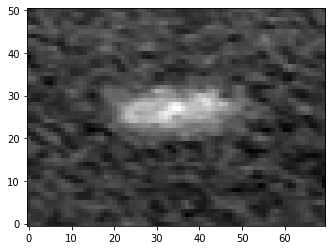

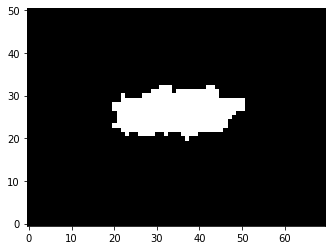

In [5]:
#周囲の余白の大きさ
PADDING_SIZE=20

#各スライスの学習データの画像サイズ
FIXED_SIZES=[128,256,256,256,128,128,256,256,256,128]

def rotate(image, angle,center):
    h, w = image.shape[:2]
    affine = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, affine, (w, h))

def load_data(cid,seg_path,vol_path):
    raw_seg = nib.load(seg_path)
    raw_vol = nib.load(vol_path)

    affine = raw_vol.affine
    raw_vol = raw_vol.get_data()
    raw_seg = raw_seg.get_data()
    return raw_vol,raw_seg 

def get_slice_idx(raw_seg):
    rnumber = len(raw_seg[0,0,:])
    imagefragarray = []
    sliceIndex = []

    #高さ方向の腎臓、腎臓がんの範囲特定
    for x in range(rnumber):
        
        imagefragarray = raw_seg[:,:,x]
        
        if np.where(imagefragarray!=0,True,False).any():
            sliceIndex.append(x)
    
    return sliceIndex

    
for q in tqdm_notebook(range(1)):
    seg_path=os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(cid).zfill(3),"segmentation.nii.gz")
    vol_path=os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(cid).zfill(3),"imaging.nii.gz")
    raw_vol,raw_seg=load_data(q)
    
    count = 0

   # print(len(imageIndex))
    sliceIndex=get_slice_idx(raw_seg)
    number = int(len(sliceIndex)/10)#特定されたスライスの枚数/10
    folder_num = 0 #スライスを10等分するための定数
    print(sliceIndex)
    for i,x in enumerate(sliceIndex):
        slice_vol=raw_vol[:,:,x]
        slice_seg=raw_seg[:,:,x]

        #領域
        contours,hierarchy = cv2.findContours(slice_seg, 1, 2)

        #最大領域の取得
        max_id=np.argmax(np.array([cv2.contourArea(cnt) for cnt in contours]))
        max_countor=contours[max_id]
        rect = cv2.minAreaRect(max_countor)

        #回転点,領域の大きさ,回転角
        center,size,degree=rect
        #角度から4座標に変換
        box = cv2.boxPoints(rect)

        #角度が0になった場合、関心領域はどこに写像されるか取得
        horizon_rect=(center,size,0)
        horizon_box = cv2.boxPoints(horizon_rect)

        #(Left,Right,Top,Bottom:X,Y)
        LX=int(horizon_box[0,0])
        RX=int(horizon_box[3,0])
        TY=int(horizon_box[0,1])
        UY=int(horizon_box[1,1])

        if LX>RX:
            LX,RX=RX,LX

        if TY>UY:
            TY,UY=UY,TY

        #画像全体を回転させる。
        rotate_vol_a=rotate(slice_vol,degree,center)
        rotate_seg_a=rotate(slice_seg,degree,center)
        
        clip_vol=rotate_vol_a[TY-PADDING_SIZE:UY+PADDING_SIZE, LX-PADDING_SIZE:RX+PADDING_SIZE]
        clip_seg=rotate_seg_a[TY-PADDING_SIZE:UY+PADDING_SIZE, LX-PADDING_SIZE:RX+PADDING_SIZE]
        box_shape=clip_seg.shape

        if q==0:
            plt.imshow(clip_vol,cmap='gray',origin='lower')
            plt.show()

            plt.imshow(clip_seg,cmap='gray',origin='lower')
            plt.show()
        
        clip_vol=cv2.resize(clip_vol,dsize=(FIXED_SIZES[folder_num],FIXED_SIZES[folder_num]),interpolation=cv2.INTER_CUBIC)
        clip_seg=cv2.resize(clip_seg,dsize=(FIXED_SIZES[folder_num],FIXED_SIZES[folder_num]),interpolation=cv2.INTER_CUBIC)
        
        if i%number==0 and folder_num < 10:
            folder_num += 1
        break


#         if q==0:
#             plt.imshow(clip_vol,cmap='gray',origin='lower')
#             plt.show()

#             plt.imshow(clip_seg,cmap='gray',origin='lower')
#             plt.show()



#         clip_seg = sitk.GetImageFromArray(clip_seg)
#         clip_vol = sitk.GetImageFromArray(clip_vol)



#        # print("saving cut to", str(q)+"imagefragment"+str(i), end="...", flush=True)
#         label_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\label_sagittal\case_00"
#         image_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\image_sagittal\case_00"

#         os.makedirs(os.path.join(label_path+str(q).zfill(3),str(folder_num)), exist_ok=True)
#         os.makedirs(os.path.join(image_path+str(q).zfill(3),str(folder_num)), exist_ok=True)

#         seg_path = os.path.join(label_path+str(q).zfill(3),str(folder_num),"label{}.mha".format(i))
#         vol_path = os.path.join(image_path+str(q).zfill(3),str(folder_num),"image{}.mha".format(i))

#         seg_jpg_path = os.path.join(label_path+str(q).zfill(3),str(folder_num),"label{}.jpg".format(i))
#         vol_jpg_path = os.path.join(image_path+str(q).zfill(3),str(folder_num),"image{}.jpg".format(i))

#         sitk.WriteImage(clip_seg, seg_path, True)
#         sitk.WriteImage(clip_vol, vol_path, True)

#         count += 1

In [33]:
degree

-78.69007110595703

In [ ]:
#変換の経過を可視化
plt.imshow(slice_seg,cmap='gray',origin='lower')
plt.show()

plt.imshow(clip_seg,cmap='gray',origin='lower')
plt.show()
clip_vol=rotate_vol_a[TY-PADDING_SIZE:UY+PADDING_SIZE, LX-PADDING_SIZE:RX+PADDING_SIZE]

clip_seg2=cv2.resize(clip_seg,dsize=(box_shape[1],box_shape[0]),interpolation=cv2.INTER_CUBIC)
plt.imshow(clip_seg2,cmap='gray',origin='lower')
plt.show()

clip_seg3=clip_seg2[20:-18, 20:-19]
plt.imshow(clip_seg3,cmap='gray',origin='lower')
plt.show()


M=cv2.getRotationMatrix2D((cols/2,rows/2),-degree,1)
M[0,2]+=center[0]
M[1,2]+=center[1]
clip_seg4=cv2.warpAffine(clip_seg3,M,(slice_seg.shape[1],slice_seg.shape[0]))
plt.imshow(clip_seg4,cmap='gray',origin='lower')
plt.show()

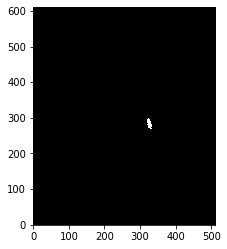

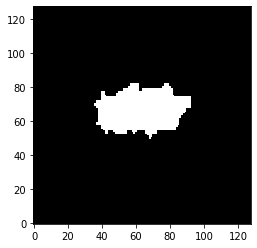

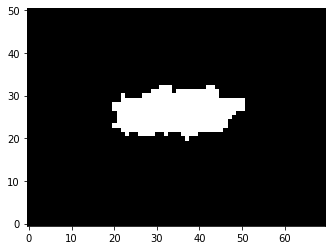

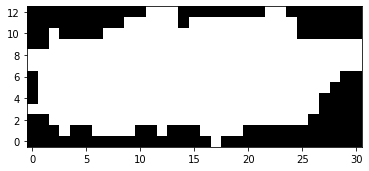

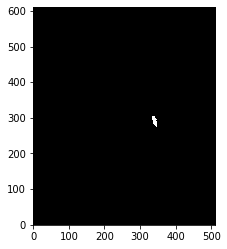

In [80]:
#変換後画像->元画像の変換
def revert_image(square_img, PADDING_SIZE, roi_shape, raw_shape, degree, center):

    tmp2 = cv2.resize(tmp, dsize=(roi_shape[1], roi_shape[0]), interpolation=cv2.INTER_CUBIC)
    tmp3 = tmp2[PADDING_SIZE:-PADDING_SIZE + 2, PADDING_SIZE:-PADDING_SIZE + 1]

    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), -degree, 1)
    M[0, 2] += center[0]
    M[1, 2] += center[1]
    raw_slice = cv2.warpAffine(square_img3, M, (raw_shape[1], raw_shape[0]))

    return raw_slice

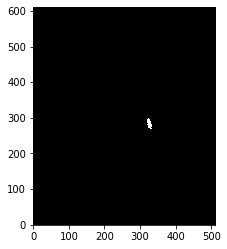

In [61]:
plt.imshow(slice_seg,cmap='gray',origin='lower')
plt.show()

In [76]:
rows,cols = clip_seg3.shape
M=cv2.getRotationMatrix2D((cols/2,rows/2),-degree,1)
M[0,2]+=center[0]
M[1,2]+=center[1]

In [77]:
M

array([[ 1.96116074e-01,  9.80580688e-01,  3.31259492e+02],
       [-9.80580688e-01,  1.96116074e-01,  3.03558859e+02]])

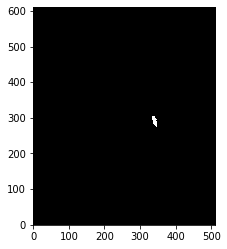

In [78]:
backimage=np.zeros(shape=(512,512))
# M = np.float32([[1,0,100],[0,1,50]])
#元画像、affine行列、変換後サイズ
clip_seg4=cv2.warpAffine(clip_seg3,M,(slice_seg.shape[1],slice_seg.shape[0]))

plt.imshow(clip_seg4,cmap='gray',origin='lower')
plt.show()

In [ ]:
#この方法だと、x,y方向の余計な部分を取り除けていない。
FIXED_SIZE=(256,256)
for q in tqdm_notebook(range(210)):
    ## Read image
    seg = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(q).zfill(3),"segmentation.nii.gz"))
    vol = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(q).zfill(3),"imaging.nii.gz"))

    affine = vol.affine
    vol = vol.get_data()
    seg = seg.get_data()

    imagefragarray = []
    imageIndex = []
    count = 0

    #sagittal
    rnumber = len(seg[0,:,0])
    
    #高さ方向の腎臓、腎臓がんの範囲特定
    for z in range(rnumber):
        imagefragarray = seg[:,:,z]
        if np.where(imagefragarray!=0,True,False).any():
            imageIndex.append(z)
    
   # print(len(imageIndex))
    number = int(len(imageIndex)/10)#特定されたスライスの枚数/10
    snumber = -1 #スライスを10等分するための定数
  #  print(number)

    #スライスの保存（imageとsegmentation）
    for i,z in enumerate(imageIndex):
        vol_im = Image.fromarray(vol[:,:,z]).resize(FIXED_SIZE,Image.NEAREST)
        seg_im = Image.fromarray(seg[:,:,z]).resize(FIXED_SIZE,Image.NEAREST)
        
        vol_im=np.asarray(vol_im)
        seg_im=np.asarray(seg_im)

        segfrag = sitk.GetImageFromArray(seg_im)
        volfrag = sitk.GetImageFromArray(vol_im)

        if i%number==0 and snumber < 10:
            snumber += 1

       # print("saving cut to", str(q)+"imagefragment"+str(i), end="...", flush=True)
        label_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\label_sagittal\case_00"
        image_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\image_sagittal\case_00"
        
        os.makedirs(os.path.join(label_path+str(q).zfill(3),str(snumber)), exist_ok=True)
        os.makedirs(os.path.join(image_path+str(q).zfill(3),str(snumber)), exist_ok=True)

        outfile1 = os.path.join(label_path+str(q).zfill(3),str(snumber),"label{}.mha".format(i))
        outfile2 = os.path.join(image_path+str(q).zfill(3),str(snumber),"image{}.mha".format(i))

        sitk.WriteImage(segfrag, outfile1, True)
        sitk.WriteImage(volfrag, outfile2, True)
        count += 1



In [8]:
#中心じゃね？
rect


((285.6220703125, 278.8923645019531),
 (191.9769744873047, 90.47527313232422),
 -55.9390869140625)

In [17]:
horizon_box

array([[189, 324],
       [189, 233],
       [381, 233],
       [381, 324]], dtype=int64)

In [30]:
padding_box

array([[179, 334],
       [179, 223],
       [391, 223],
       [391, 334]], dtype=int64)

In [20]:
Image.fromarray(rotate_im_a[223:334, 179:391])

[179, 223]

In [26]:
horizon_box
padding_box=np.array([[horizon_box[0,0]-10,horizon_box[0,1]+10],
                     [horizon_box[1,0]-10,horizon_box[1,1]-10],
                     [horizon_box[2,0]+10,horizon_box[2,1]-10],
                     [horizon_box[3,0]+10,horizon_box[3,1]+10],
                     ])

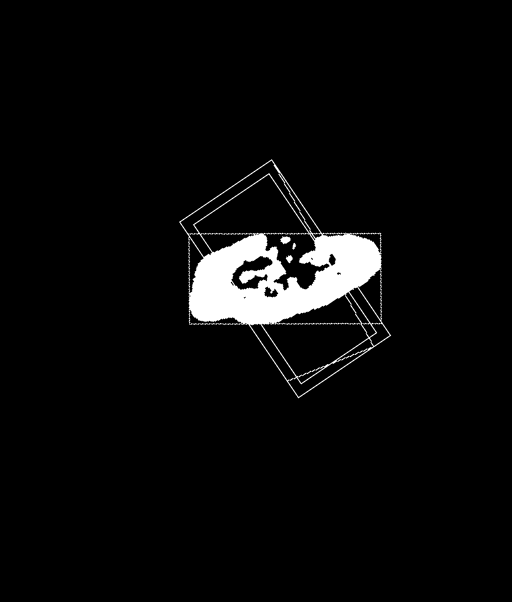

In [33]:
rotate_im

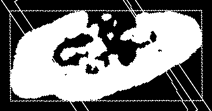

In [35]:
#(y,xの順番になるのに注意)
# Image.fromarray(thresh[223:334, 179:391])
rotate_im_a=rotate(im,-55.93,(285,278))
Image.fromarray(rotate_im_a[223:334, 179:391])


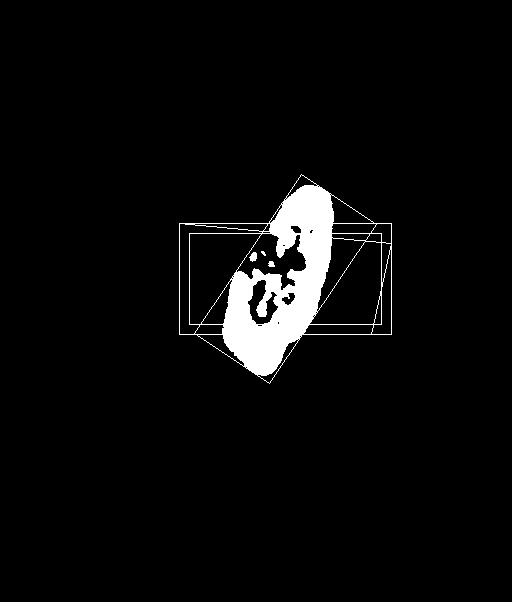

In [27]:
cnt=contours[8]
#box2Dの形で帰ってくる(左上の点(x,y)，横と縦のサイズ(width, height)，回転角)
rect = cv2.minAreaRect(cnt)
#長方形の4隅の点に変更
box = cv2.boxPoints(rect)
horizon_rect=(rect[0],rect[1],0)
horizon_box = cv2.boxPoints(horizon_rect)

#引数が(x,y)で格納されている
box = np.int0(box)
horizon_box=np.int0(horizon_box)

# 引数1:入力画像, 引数2:listとして保存されている輪郭,　引数3:描画したい輪郭のインデックス  ,4以降描画の色と太さ
im = cv2.drawContours(thresh,[horizon_box,box,padding_box],2,(255,255,255),1)
Image.fromarray(im)

In [32]:
def rotate(image, angle,center):
    h, w = image.shape[:2]
    affine = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, affine, (w, h))

rotate_im=Image.fromarray(rotate(im,-55.93,(285,278)))

In [ ]:
def rot_cut(src_img, deg, center, size):
    rot_mat = cv2.getRotationMatrix2D(center, deg, 1.0)
    rot_mat[0][2] += -center[0]+size[0]/2 # -(元画像内での中心位置)+(切り抜きたいサイズの中心)
    rot_mat[1][2] += -center[1]+size[1]/2 # 同上
    return cv2.warpAffine(src_img, rot_mat, size)

In [62]:
cv2.resize(tmp_vol,dsize=(256,256),interpolation=cv2.INTER_CUBIC)

array([[-1011.08662414, -1011.29212021, -1024.83463842, ...,
         -919.88816615,  -910.0378372 ,  -912.14931367],
       [-1021.54345826, -1015.51282578, -1009.91758298, ...,
         -903.22302276,  -914.59441904,  -923.32290457],
       [ -994.42279479,  -995.65967628,  -983.9437082 , ...,
         -924.09707043,  -923.80055736,  -913.29818204],
       ...,
       [-1009.52943344, -1002.65815392,  -990.4436855 , ...,
         -921.74778295,  -886.9437423 ,  -914.04873853],
       [-1019.29051748, -1005.66598084, -1017.24448082, ...,
         -950.22917042,  -938.67735113,  -916.18281867],
       [-1019.00389936, -1000.68904997, -1009.56371116, ...,
         -937.50968157,  -917.96777101,  -924.24193066]])

In [59]:
#volデータの確認
tmp_vol=vol[:,:,150]
#CT値を255に戻す
fix_vol=((tmp_vol+abs(tmp_vol.min()))*255/(abs(tmp_vol.min())+abs(tmp_vol.max()))).astype(np.uint8)

# Image.fromarray(rotate(fix_vol,-55.93,(285,278)))
rotate_vol_a=rotate(fix_vol,-55.93,(285,278))
mini_vol=rotate_vol_a[223:334, 179:391]
mini_vol_im=Image.fromarray(mini_vol)

TypeError: fromarray() got an unexpected keyword argument 'interpolation'

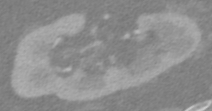

In [44]:
mini_vol_im

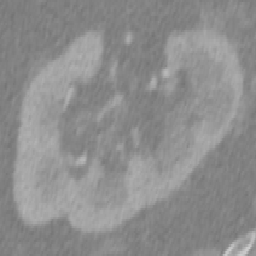

In [43]:
mini_vol_im.resize((256,256))

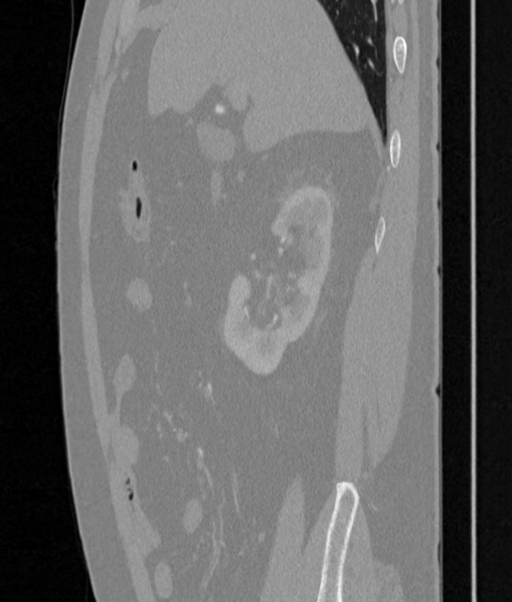

In [30]:
rotate_im_a=rotate(im,-55.93,(285,278))
Image.fromarray(rotate_im_a[223:334, 179:391])

((295.0, 245.0), (48.0, 114.0), -0.0)

In [39]:
%%time
#被験者00001を観察
#nib_ver

#{"case_id": "case_00001", "captured_pixel_width": 0.798828125, "captured_slice_thickness": 0.5}
print(seg[:,:,:].shape)
tmp_im=seg[:,:,170]
#slicerに合わせるように回転したのち反転してる
#0以外の部分はすべて255に変換している。
ret2,thresh2 = cv2.threshold(tmp_im,0,255,0)
contours2,hierarchy2 = cv2.findContours(thresh2, 1, 2)

for i,contour in enumerate(contours2):
    cnt = contour

    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
#     print ('重心:',M)
    print (f'{i}:面積:',area,'周囲長:',perimeter)



cnt2=contours2[2]
#box2Dの形で帰ってくる(左上の点(x,y)，横と縦のサイズ(width, height)，回転角)
rect2 = cv2.minAreaRect(cnt2)
#長方形の4隅の点に変更
box2 = cv2.boxPoints(rect2)


#引数が(x,y)で格納されている
box2 = np.int0(box2)


# 引数1:入力画像, 引数2:listとして保存されている輪郭,　引数3:描画したい輪郭のインデックス  ,4以降描画の色と太さ
im2 = cv2.drawContours(thresh2,[box2],0,(255,255,255),1)


(602, 512, 512)
0:面積: 11.5 周囲長: 19.899494767189026
1:面積: 10.0 周囲長: 18.485281229019165
2:面積: 4028.0 周囲長: 332.93607199192047
Wall time: 12 ms


In [42]:
box2

array([[271, 302],
       [271, 188],
       [319, 188],
       [319, 302]], dtype=int64)

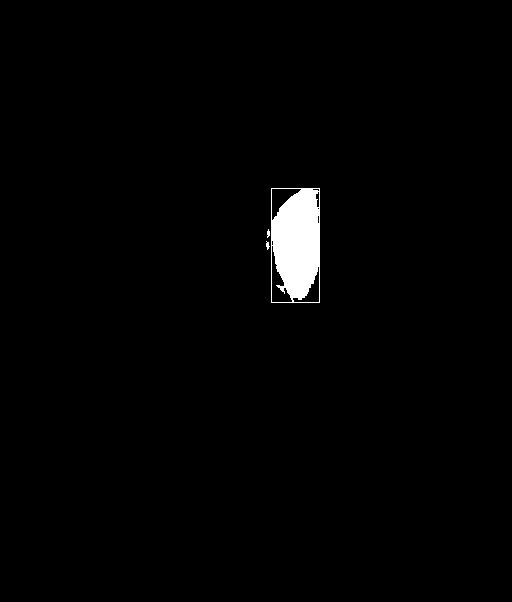

In [40]:
Image.fromarray(im2)

In [41]:
rect2

((295.0, 245.0), (48.0, 114.0), -0.0)

In [ ]:
Image.fromarray(rotate(im2,-55.93,(285,278)))

In [108]:
%%time
#sitk_ver

#被験者00001を観察
seg_img = sitk.ReadImage(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"segmentation.nii.gz"))
ct_img = sitk.ReadImage(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(1).zfill(3),"imaging.nii.gz"))

seg_array = sitk.GetArrayFromImage(seg_img)
ct_array = sitk.GetArrayFromImage(ct_img)

#{"case_id": "case_00001", "captured_pixel_width": 0.798828125, "captured_slice_thickness": 0.5}
print(seg_array[:,:,:].shape)
tmp_im=seg_array[:,260,:]



# tmp_im=np.where(tmp_im==1,127,tmp_im)
# tmp_im=np.where(tmp_im==2,255,tmp_im)
# pil_img = Image.fromarray(tmp_im)
# print(pil_img.size)
# #slicerに合わせるように回転したのち反転してる
# img=ImageOps.mirror(pil_img.rotate(270))
# img

(512, 512, 602)
0:面積: 150.5 周囲長: 59.21320283412933
1:面積: 15.0 周囲長: 14.485281229019165
2:面積: 241.5 周囲長: 86.66904652118683
3:面積: 85.5 周囲長: 38.38477599620819
4:面積: 1.0 周囲長: 6.828427076339722
5:面積: 19.5 周囲長: 21.071067690849304
6:面積: 9872.0 周囲長: 622.3574253320694
7:面積: 15.5 周囲長: 15.071067690849304
8:面積: 26.5 周囲長: 20.727921843528748
9:面積: 63.0 周囲長: 32.14213526248932
10:面積: 48.0 周囲長: 30.97056233882904
11:面積: 21.0 周囲長: 17.313708186149597
12:面積: 7391.5 周囲長: 645.712764620781
Wall time: 6.08 s


In [74]:
img=np.asarray(img)

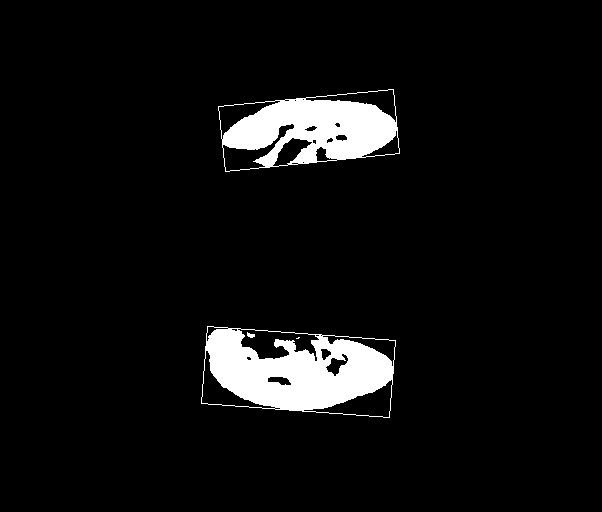

In [75]:
Image.fromarray(thresh)

In [61]:
len(contours)

13

In [91]:
ret,thresh = cv2.threshold(tmp_im,0,255,0)
# #輪郭を見つける args2...contour_retrievalmode  args3...輪郭検出方法
#この場合13か所の輪郭がlistで格納されている
contours,hierarchy = cv2.findContours(thresh, 1, 2)

for i,contour in enumerate(contours):
    cnt = contour

    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
#     print ('重心:',M)
    print (f'{i}:面積:',area,'周囲長:',perimeter)



In [90]:
cnt=contours[6]
cnt2=contours[2]

#box2Dの形で帰ってくる(左上の点(x,y)，横と縦のサイズ(width, height)，回転角)
rect = cv2.minAreaRect(cnt)
#長方形の4隅の点に変更
box = cv2.boxPoints(rect)

rect2 = cv2.minAreaRect(cnt2)
#長方形の4隅の点に変更
box2 = cv2.boxPoints(rect2)


#引数が(x,y)で格納されている
box = np.int0(box)
box2 = np.int0(box2)

# 引数1:入力画像, 引数2:listとして保存されている輪郭,　引数3:描画したい輪郭のインデックス  ,4以降描画の色と太さ
im = cv2.drawContours(thresh,[box,box2],1,(255,255,255),1)
Image.fromarray(im)

IndexError: list index out of range

In [29]:
M = cv2.moments(cnt)
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt,True)
print ('重心:',M)
print ('面積:',area)
print ('周囲長:',perimeter)

重心: {'m00': 150.5, 'm10': 42013.666666666664, 'm01': 57210.33333333333, 'm20': 11734508.25, 'm11': 15971820.791666666, 'm02': 21748442.583333332, 'm30': 3279127708.8, 'm21': 4461231438.65, 'm12': 6072032185.85, 'm03': 8267944788.200001, 'mu20': 5948.869416760281, 'mu11': 951.1932908836752, 'mu02': 786.5028608366847, 'mu30': -5751.307564735413, 'mu21': 1839.1751336432062, 'mu12': 1266.3431747092109, 'mu03': 324.0469570159912, 'nu20': 0.2626403424580427, 'nu11': 0.04199482526169359, 'nu02': 0.03472380485145571, 'nu30': -0.020697855151056672, 'nu21': 0.006618839296125113, 'nu12': 0.004557326713384752, 'nu03': 0.0011661829771689894}
面積: 150.5
周囲長: 59.21320283412933


In [30]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
im = cv2.drawContours(im,[box],0,(0,0,255),2)

In [33]:
rect

((279.0, 380.5), (24.0, 9.0), -0.0)

(602, 512)


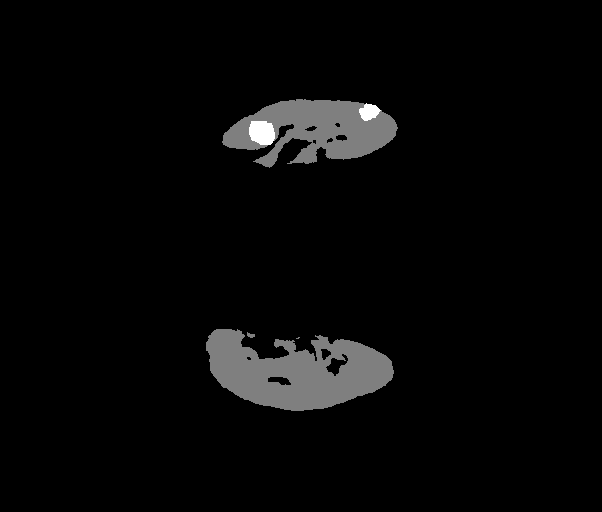

In [32]:
pil_img = Image.fromarray(im)
print(pil_img.size)
#slicerに合わせるように回転したのち反転してる
img=ImageOps.mirror(pil_img.rotate(270))
img

In [12]:
#この方法だと、x,y方向の余計な部分を取り除けていない。
FIXED_SIZE=(256,256)
for q in tqdm_notebook(range(210)):
    ## Read image
    seg = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(q).zfill(3),"segmentation.nii.gz"))
    vol = nib.load(os.path.join(r"C:\Users\higuchi\Desktop\kits19\data\case_00"+str(q).zfill(3),"imaging.nii.gz"))

    affine = vol.affine
    vol = vol.get_data()
    seg = seg.get_data()

    imagefragarray = []
    imageIndex = []
    count = 0

    #sagittal
    rnumber = len(seg[0,:,0])
    
    #高さ方向の腎臓、腎臓がんの範囲特定
    for z in range(rnumber):
        imagefragarray = seg[:,:,z]
        if np.where(imagefragarray!=0,True,False).any():
            imageIndex.append(z)
    
   # print(len(imageIndex))
    number = int(len(imageIndex)/10)#特定されたスライスの枚数/10
    snumber = -1 #スライスを10等分するための定数
  #  print(number)

    #スライスの保存（imageとsegmentation）
    for i,z in enumerate(imageIndex):
        vol_im = Image.fromarray(vol[:,:,z]).resize(FIXED_SIZE,Image.NEAREST)
        seg_im = Image.fromarray(seg[:,:,z]).resize(FIXED_SIZE,Image.NEAREST)
        
        vol_im=np.asarray(vol_im)
        seg_im=np.asarray(seg_im)

        segfrag = sitk.GetImageFromArray(seg_im)
        volfrag = sitk.GetImageFromArray(vol_im)

        if i%number==0 and snumber < 10:
            snumber += 1

       # print("saving cut to", str(q)+"imagefragment"+str(i), end="...", flush=True)
        label_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\label_sagittal\case_00"
        image_path=r"C:\Users\higuchi\Desktop\LAB\201906_\segmentation\data\image_sagittal\case_00"
        
        os.makedirs(os.path.join(label_path+str(q).zfill(3),str(snumber)), exist_ok=True)
        os.makedirs(os.path.join(image_path+str(q).zfill(3),str(snumber)), exist_ok=True)

        outfile1 = os.path.join(label_path+str(q).zfill(3),str(snumber),"label{}.mha".format(i))
        outfile2 = os.path.join(image_path+str(q).zfill(3),str(snumber),"image{}.mha".format(i))

        sitk.WriteImage(segfrag, outfile1, True)
        sitk.WriteImage(volfrag, outfile2, True)
        count += 1



KeyboardInterrupt: 